Our objective is to make a 6 weeks sales prediction for 1115 Rossmann stores. We will do data cleaning and EDA. In a first step, we will apply univariate time series and fit a model to each store and we will see how far we come with only the sales data. After that, we will use feature engineering to apply advanced supervised learning algorithms.

In [62]:
from autotimeseries.core import AutoTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



##### Short description:
- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

In [63]:
# Load data
train = pd.read_csv("./rossmann-store-sales/train.csv", low_memory=False, index_col="Date", parse_dates=True)
store = pd.read_csv("./rossmann-store-sales/store.csv")

# Shape of each dataset
print("The train dataset has the following shape:", train.shape)
print("The store dataset has the following shape:", store.shape)

# Lets look at the first 5 rows of the train dataset
print("\nThe first 5 rows of the train dataset:")
train.head()

The train dataset has the following shape: (1017209, 8)
The store dataset has the following shape: (1115, 10)

The first 5 rows of the train dataset:


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [64]:
print(train.index)
print("\nThe train dataset consists of daily sales data for 1115 Rossmann stores from 01/01/2013 to 07/31/2015.")

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

The train dataset consists of daily sales data for 1115 Rossmann stores from 01/01/2013 to 07/31/2015.


In [65]:
# Number of unique Stores in the train dataset
print(train["Store"].nunique())

print(f"In the train dataset we are dealing with {train.shape[0]} entries and {train.shape[1]} features.")

1115
In the train dataset we are dealing with 1017209 entries and 8 features.


### Handling Missing Values

In [66]:
train.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


We don't have any missing data. That's great. Let's proceed.

### Checking for Correlations

<AxesSubplot: xlabel='Date'>

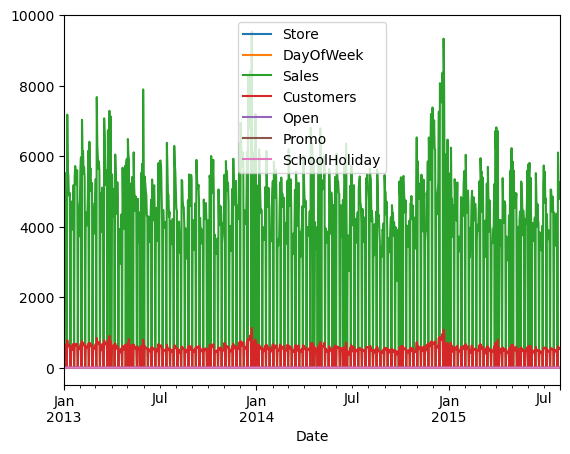

In [68]:
train[(train.Store == 1)].plot()

In [69]:
corr_matrix = train.corr()

In [70]:
corr_matrix

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,1.000000,-0.000008,0.005126,0.024325,-0.000047,0.000058,0.000641
DayOfWeek,-0.000008,1.000000,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388
Sales,0.005126,-0.462125,1.000000,0.894711,0.678472,0.452345,0.085124
Customers,0.024325,-0.386445,0.894711,1.000000,0.616768,0.316169,0.071568
Open,-0.000047,-0.528963,0.678472,0.616768,1.000000,0.295042,0.086171
Promo,0.000058,-0.392925,0.452345,0.316169,0.295042,1.000000,0.067483
SchoolHoliday,0.000641,-0.205388,0.085124,0.071568,0.086171,0.067483,1.000000


In [71]:
corr_matrix["Sales"].sort_values(ascending=False)

Sales            1.000000
Customers        0.894711
Open             0.678472
Promo            0.452345
SchoolHoliday    0.085124
Store            0.005126
DayOfWeek       -0.462125
Name: Sales, dtype: float64

We will not use "Customer" because in real out-of-sample forecasts we would not know the true number of customers.

In [72]:
print(train["Sales"].value_counts())
print(train["Open"].value_counts())
print(train["Promo"].value_counts())
print(train["DayOfWeek"].value_counts())

0        172871
5674        215
5558        197
5483        196
6214        195
          ...  
23806         1
24183         1
20651         1
25083         1
23303         1
Name: Sales, Length: 21734, dtype: int64
1    844392
0    172817
Name: Open, dtype: int64
0    629129
1    388080
Name: Promo, dtype: int64
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: DayOfWeek, dtype: int64


In [73]:
df_s1 = train[(train.Store == 1)]

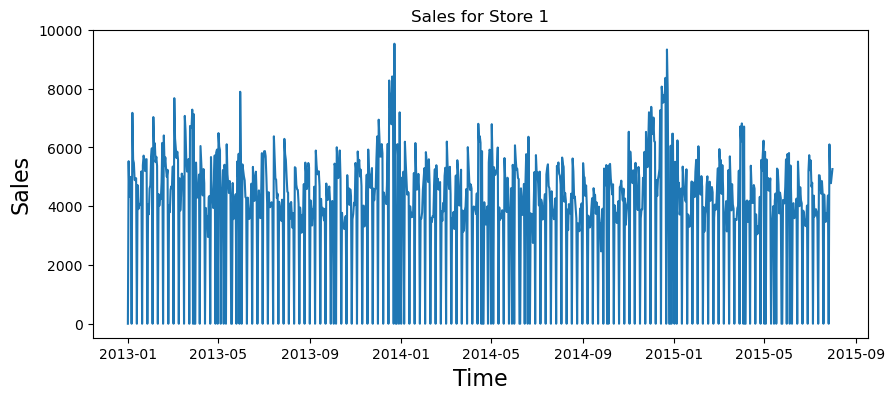

In [74]:
plt.figure(figsize=(10,4))
plt.plot(df_s1["Sales"])
plt.title("Sales for Store 1")
plt.ylabel("Sales", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.show()

### Model Training

In [75]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    return df

In [76]:
df_s1 = create_features(df_s1)

Text(0.5, 1.0, 'Sales by Day')

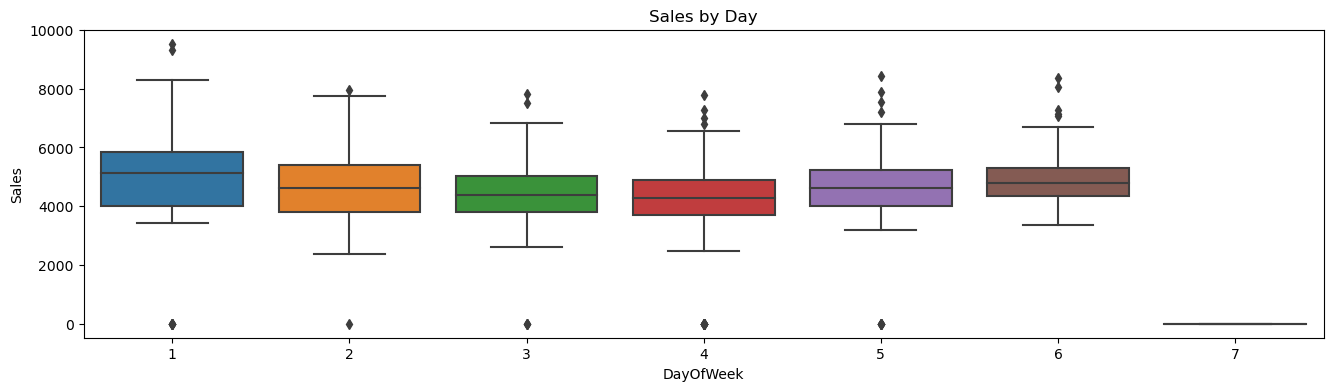

In [77]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxplot(data=df_s1, x="DayOfWeek", y="Sales")
ax.set_title("Sales by Day")


In [78]:
df_s1.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [79]:
FEATURES_num = ['Store', 'DayOfWeek', 'Open', 'Promo',
            'SchoolHoliday', 'quarter', 'month', 'year',
            'dayofyear']
TARGET = "Sales"
test_s1 = df_s1.iloc[:49]
train_s1 = df_s1.iloc[49:]


In [80]:
X_train = train_s1[FEATURES_num]
y_train = train_s1[TARGET]

X_test = test_s1[FEATURES_num]
y_test = test_s1[TARGET]


In [81]:
reg = xgb.XGBRegressor(base_score=0.5, booster="gbtree",
                       n_estimators=500,
                       early_stopping_rounds=50,
                       objective="reg:linear",
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
        )


[20:43:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4401.92282	validation_1-rmse:4098.41606
[100]	validation_0-rmse:1737.93095	validation_1-rmse:1394.30746
[200]	validation_0-rmse:864.05232	validation_1-rmse:540.66463
[300]	validation_0-rmse:616.65777	validation_1-rmse:382.75185
[400]	validation_0-rmse:536.32815	validation_1-rmse:375.73365
[417]	validation_0-rmse:528.20803	validation_1-rmse:376.54116


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [82]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_, columns=['importance'])


<AxesSubplot: title={'center': 'Feature Importance'}>

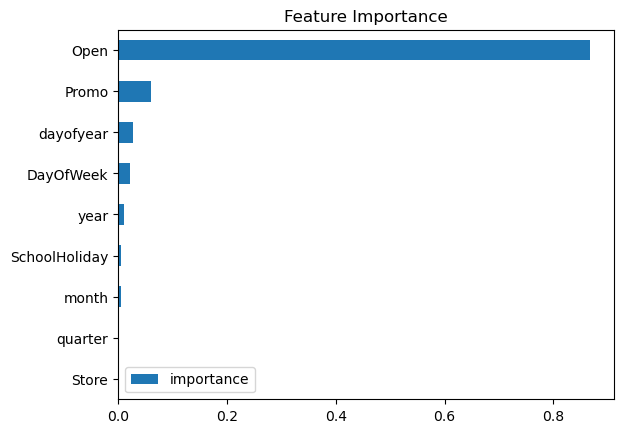

In [83]:
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")

In [84]:
test_s1["prediction"] = reg.predict(X_test)


In [85]:
df_s1 = df_s1.merge(test_s1[["prediction"]], how="left",
              left_index=True, right_index=True)


Text(0.5, 1.0, 'Raw Data and Predictions')

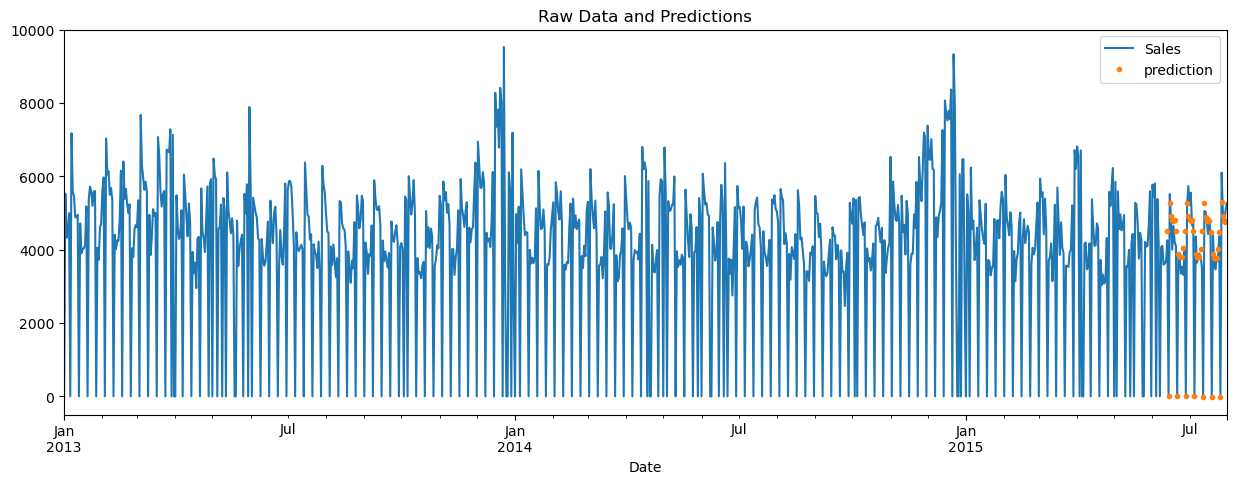

In [86]:
ax = df_s1[["Sales"]].plot(figsize=(15,5))
df_s1["prediction"].plot(ax=ax, style=".")
ax.legend()
ax.set_title("Raw Data and Predictions")

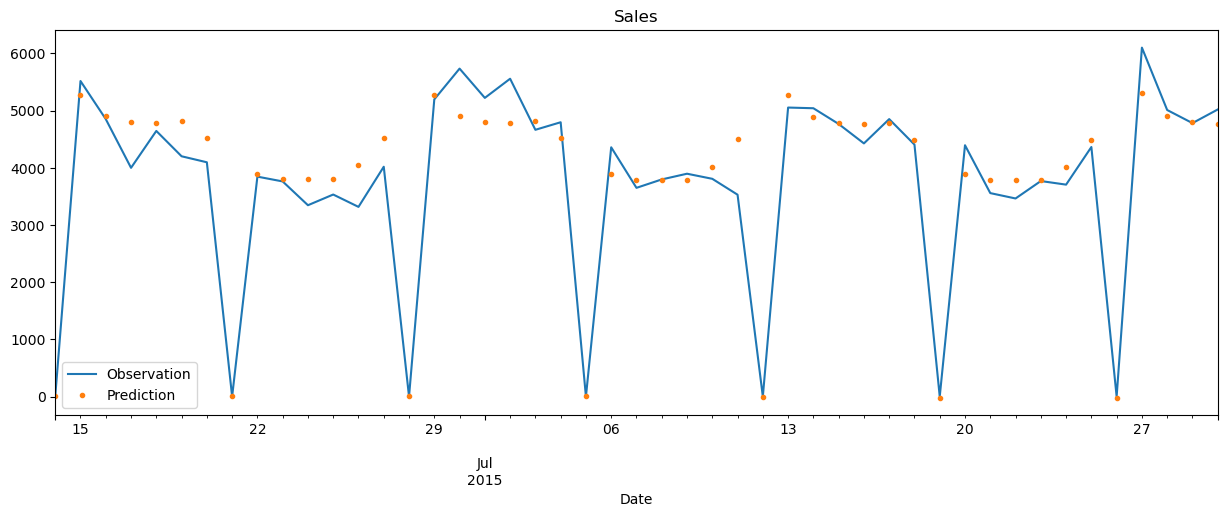

In [87]:
ax = df_s1.loc[(df_s1.index > "2015-06-13") & (df_s1.index < "2015-07-31")]["Sales"].plot(figsize=(15, 5), title="Sales")
df_s1.loc[(df_s1.index > "2015-06-13") & (df_s1.index < "2015-07-31")]["prediction"].plot(style=".")
plt.legend(["Observation", "Prediction"])
plt.show()
